In [1]:
import os
import sys
import math
import time
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from skimage.transform import resize
from scipy import ndimage
import cupy
import cupyx.scipy.ndimage
# from cupyx.scipy import ndimage

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [2]:
# folder path of optical fields
opt_field = './Projections_test/'
# opt_field = './Data/'

n_med = 1.334
wavelength = 532
CameraPixelSize = 5.5
mag = 85
ffsize = 512


n_med2 = n_med*n_med
wavelength = wavelength * 1e-9

f0 = 1/wavelength
fm0  = f0*n_med
fm02 = fm0*fm0


dx     = CameraPixelSize * 1e-6 / mag * 1024 / ffsize


# Wave vector
k = 2*np.pi*n_med/wavelength
k2 = k*k
# 每一個grid的frequency resolution
df = 1/(ffsize*dx)

In [3]:
dt_PM = np.dtype({'names': ['status', 'angleX', 'angleY', 'sizeX', 'sizeY', 'cImg'],
               'formats': ['?', '<f8', '<f8', '<i4', '<i4', '(1024,1024,2)<f4']});

def importOpticalField(filePath):
    
    data = np.fromfile(filePath, dtype=dt_PM)
    data = data[0]
    reconFlag = data['status']
    angX = data['angleX']
    angY = data['angleY']
    phiImg = data['cImg'][:,:,0]
    ampImg = data['cImg'][:,:,1]
    
    return reconFlag, angX, angY, phiImg, ampImg


def gpu_resize(dPhi, dAmp, src_x, src_y, nx, ny):
    ratio_x = nx/src_x
    ratio_y = ny/src_y
    dPhi[cupy.isnan(dPhi)] = 0
    dPhi[cupy.isinf(dPhi)] = 0
    dAmp[cupy.isnan(dAmp)] = 1
    dAmp[cupy.isinf(dAmp)] = 1
    dAmp[cupy.equal(dAmp,0.0)] = 0.01;
    dAmp = cupy.absolute(dAmp)
        
    dPhi = cupyx.scipy.ndimage.zoom(dPhi, (ratio_y,ratio_x))
    dAmp = cupyx.scipy.ndimage.zoom(dAmp, (ratio_y,ratio_x))
    dField = cupy.log(dAmp) + 1j*(dPhi)
    return dField

def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def plot_F_domain(f, ffsize, df):
    xticks = [-ffsize//2*df, ffsize//2*df]
    yticks = [-ffsize//2*df, ffsize//2*df]
    zticks = [-ffsize//2*df, ffsize//2*df] 
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),sharex=True, sharey=False)
    ax1=axes[0]
    ax2=axes[1]
    ax3=axes[2]
    xy = np.log10(np.abs(f[:,:,ffsize//2]))
    xz = np.log10(np.abs(f[:,ffsize//2,:]))
    yz = np.log10(np.abs(f[ffsize//2,:,:]))
    ax1.imshow(np.transpose(xy), cmap=plt.cm.inferno)
    ax2.imshow(np.transpose(xz), cmap=plt.cm.inferno)
    ax3.imshow(np.transpose(yz), cmap=plt.cm.inferno)
    ax1.set_xlabel('fx(n${_0}$/λ)', fontsize=16), ax1.set_ylabel('fy(n${_0}$/λ)', fontsize=16)
#     ax1.set_xlim(xticks), ax1.set_ylim(yticks)
    ax2.set_xlabel('fx(n${_0}$/λ)', fontsize=16), ax2.set_ylabel('fz(n${_0}$/λ)', fontsize=16)
#     ax2.xaxis.set_xticks(xticks), ax2.xaxis.set_yticks(zticks)
    ax3.set_xlabel('fy(n${_0}$/λ)', fontsize=16), ax3.set_ylabel('fz(n${_0}$/λ)', fontsize=16)
#     ax3.xaxis.set_xticks(yticks), ax3.xaxis.set_yticks(zticks)
    plt.show() 
    
    
    
MedianFilter_gpu = cupy.RawKernel(r'''
    #define MEDIAN_DIMENSION  3 // For matrix of 3 x 3. We can Use 5 x 5 , 7 x 7 , 9 x 9......   
    #define MEDIAN_LENGTH 9   // Shoul be  MEDIAN_DIMENSION x MEDIAN_DIMENSION = 3 x 3
    #define BLOCK_WIDTH 32  // Should be 8 If matrix is of larger then of 5 x 5 elese error occur as " uses too much shared data "  at surround[BLOCK_WIDTH*BLOCK_HEIGHT][MEDIAN_LENGTH]
    #define BLOCK_HEIGHT 32// Should be 8 If matrix is of larger then of 5 x 5 elese error occur as " uses too much shared data "  at surround[BLOCK_WIDTH*BLOCK_HEIGHT][MEDIAN_LENGTH]
    
    extern "C" {
        __global__ void MedianFilter_gpu(float *Device_ImageData, int Image_Width, int Image_Height)
        {
            __shared__ float surround[BLOCK_WIDTH*BLOCK_HEIGHT][MEDIAN_LENGTH];

            int iterator;
            const int Half_Of_MEDIAN_LENGTH = (MEDIAN_LENGTH / 2) + 1;
            int StartPoint = MEDIAN_DIMENSION / 2;
            int EndPoint = StartPoint + 1;

            const int x = blockDim.x * blockIdx.x + threadIdx.x;
            const int y = blockDim.y * blockIdx.y + threadIdx.y;

            const int tid = threadIdx.y*blockDim.y + threadIdx.x;

            if (x >= Image_Width || y >= Image_Height)
                return;

            //Fill surround with pixel value of Image in Matrix Pettern of MEDIAN_DIMENSION x MEDIAN_DIMENSION
            if (x == 0 || x == Image_Width - StartPoint || y == 0 || y == Image_Height - StartPoint)
            {
            }
            else
            {
                iterator = 0;
                for (int r = x - StartPoint; r < x + (EndPoint); r++)
                {
                    for (int c = y - StartPoint; c < y + (EndPoint); c++)
                    {
                        surround[tid][iterator] = *(Device_ImageData + (c*Image_Width) + r);
                        iterator++;
                    }
                }
                //Sort the Surround Array to Find Median. Use Bubble Short  if Matrix oF 3 x 3 Matrix
                //You can use Insertion commented below to Short Bigger Dimension Matrix  

                ////      bubble short //

                for (int i = 0; i<Half_Of_MEDIAN_LENGTH; ++i)
                {
                    // Find position of minimum element
                    int min = i;
                    for (int l = i + 1; l<MEDIAN_LENGTH; ++l)
                    if (surround[tid][l] <surround[tid][min])
                        min = l;
                    // Put found minimum element in its place
                    float temp = surround[tid][i];
                    surround[tid][i] = surround[tid][min];
                    surround[tid][min] = temp;
                }//bubble short  end

                // it will give value of surround[tid][4] as Median Value if use 3 x 3 matrix
                *(Device_ImageData + (y*Image_Width) + x) = surround[tid][Half_Of_MEDIAN_LENGTH - 1];

                __syncthreads();
            }
        }
    }
    ''', name='MedianFilter_gpu')

EwaldSphere_kernel = cupy.RawKernel(r'''
    #define M_PI 3.14159265358979323846
    #include <cupy/complex.cuh>
    extern "C" {
        __device__ int cuMod(int a, int b)
            {
                return (((a < 0) ? ((a % b) + b) : a) % b);
            }

        __device__ float cuRound(float num)
            {
                return (num > 0.0) ? floor(num + 0.5) : ceil(num - 0.5);
            }

        __global__ void fillEwaldSphere(float2* u_sp, float2* F, int* C, 
                                               float fx0, float fy0, float fz0, float fm0, 
                                               float df, int sizeX, int sizeY, int sizeZ) {
            bool Fz_err;
            float Fx, Fy, Fz, fx, fy, fz, tmp_fz;
            int ii, jj, Nx, Ny, Nz, idx;
            float fm02 = fm0 * fm0;
            int i = blockDim.x * blockIdx.x + threadIdx.x;
            int j = blockDim.y * blockIdx.y + threadIdx.y;

            if (i < sizeX && j < sizeY)
            {
                ii = i - (sizeX / 2.0f);
                jj = j - (sizeY / 2.0f);
                Fx = ii * df;
                Fy = jj * df;

                fx = Fx + fx0;
                fy = Fy + fy0;
                tmp_fz = (fm02 - (fx*fx + fy*fy));

                if ((fm02 - fx0*fx0 - fy0*fy0)<0 || tmp_fz<0)
                    Fz_err = true;
                else {
                    Fz_err = false;
                    fz = sqrt(tmp_fz);
                    Fz = fz - fz0;
                }                        

                Nx = cuRound(Fx/df);
                Ny = cuRound(Fy/df);

                if ( !Fz_err && Nx >= -sizeX / 2 && Nx<sizeX / 2 && Ny >= -sizeY / 2 && Ny<sizeY / 2)
                {
                    Nx = cuMod(Nx , sizeX);
                    Ny = cuMod(Ny , sizeY);
                    Nz = cuMod(cuRound(Fz / df), sizeZ);
                    idx = Nx + Ny*sizeX + Nz*sizeX*sizeY;
                    F[idx].x += (-fz * 4 * M_PI * u_sp[Nx + Ny*sizeX].y);
                    F[idx].y += ( fz * 4 * M_PI * u_sp[Nx + Ny*sizeX].x);
                    atomicAdd(&C[idx], 1);
                }
            }        
        }
    }
    ''', name='fillEwaldSphere')

In [4]:
EwaldSphere_kernel2 = cupy.RawKernel(r'''
    #define M_PI 3.14159265358979323846
    #include <cupy/complex.cuh>
    extern "C" {
        __device__ int cuMod(int a, int b)
            {
                return (((a < 0) ? ((a % b) + b) : a) % b);
            }

        __device__ float cuRound(float num)
            {
                return (num > 0.0) ? floor(num + 0.5) : ceil(num - 0.5);
            }

        __global__ void fillEwaldSphere(float2* u_sp, float2* F, int* C, 
                                        float fx0, float fy0, float fz0, float angX, float angY, float fm0,
                                        float df, int sizeX, int sizeY, int sizeZ) {
            bool Fz_err;
            float Fx, Fy, Fz, fx, fy, fz, tmp_fz;
            int ii, jj, Nx, Ny, Nz, Nx2, Ny2, Nz2, idx;
            float fm02 = fm0 * fm0;
            int i = blockDim.x * blockIdx.x + threadIdx.x;
            int j = blockDim.y * blockIdx.y + threadIdx.y;

            if (i < sizeX && j < sizeY)
            {
                ii = i - (sizeX / 2.0f);
                jj = j - (sizeY / 2.0f);
                Fx = ii * df;
                Fy = jj * df;
                fx = Fx + fx0;
                fy = Fy + fy0;
                tmp_fz = fm02 - (fx*fx + fy*fy);

                if (tmp_fz<0)
                    Fz_err = true;
                else {
                    Fz_err = false;
                    fz = sqrt(tmp_fz);
                    Fz = fz-fz0;
                    
                    if( fm02 * 2 < fx*fx+fy*fy) Fz_err=true;
                }                        

                Nx = cuRound(Fx/df);
                Ny = cuRound(Fy/df);
                

                if ( !Fz_err && Nx >= -sizeX / 2 && Nx<sizeX / 2 && Ny >= -sizeY / 2 && Ny<sizeY / 2)
                {
                    Nz = cuRound(Fz/df);
                    
                    Nx2 = Nx*cos(angX)-Nz*sin(angX);
                    Nz2 = Nx*sin(angX)+Nz*cos(angX);
                    
                    if ( Nx2 >= -sizeX / 2 && Nx2<sizeX / 2 && Nz2 >= -sizeY / 2 && Nz2<sizeY / 2) 
                    {
                        Nx = cuMod(Nx , sizeX);
                        Ny = cuMod(Ny , sizeY);

                        Nx2 = cuMod(Nx2 , sizeX);
                        Nz2 = cuMod(Nz2 , sizeY);
                        //Nz = cuMod(cuRound(Fz / df), sizeZ);

                        idx = Nx2 + Nz2*sizeX + Ny*sizeX*sizeY;
                        F[idx].x += (-fz * 2 * M_PI * u_sp[Nx + Ny*sizeX].y);
                        F[idx].y += ( fz * 2 * M_PI * u_sp[Nx + Ny*sizeX].x);
                        atomicAdd(&C[idx], 1);
                    }
                }
            }        
        }
    }
    ''', name='fillEwaldSphere')

# Ref: Diffraction microtomography with sample rotation: influence of a missing apple core in the recorded frequency space

In [5]:
improveES = cupy.RawKernel(r'''
    #define M_PI 3.14159265358979323846
    #include <cupy/complex.cuh>
    extern "C" {                
        __global__ void improveES(float2* F_dst, float2* F, int* C, float fx0, float fy0, float fz0,
                               float fm0, float df, int sizeX, int sizeY, int sizeZ) {
            bool Fz_err;
            float Fx, Fy, Fz, fx, fy, fz, tmp_fz;
            float ii, jj, kk;
            float fm02 = fm0 * fm0;
            int i = blockDim.x * blockIdx.x + threadIdx.x;
            int j = blockDim.y * blockIdx.y + threadIdx.y;
            int k = blockDim.z * blockIdx.z + threadIdx.z;
            unsigned int idx = i + j*sizeX + k*sizeX*sizeY;

            if (i>0 && j>0 && k>0 &&i < sizeX-1 && j < sizeY-1 && k < sizeZ-1)
            {
                idx = i + j*sizeX + k*sizeX*sizeY;
                ii = i - (sizeX / 2.0f);
                jj = j - (sizeY / 2.0f);
                kk = k - (sizeZ / 2.0f);
                
                Fx = ii * df;
                Fy = jj * df;
                Fz = kk * df;
                
                if (Fx*Fx + Fy*Fy +Fz*Fz < fm02*2)
                {
                    float ang = atan2(jj,ii);
                    float es_cx = fm0*cos(ang), es_cy = fm0*sin(ang), es_cz = 0.f;
                    float d = sqrt((Fx-es_cx)*(Fx-es_cx) + (Fy-es_cy)*(Fy-es_cy) + (Fz-es_cz)*(Fz-es_cz));
                                        
                    float maxI = sizeX/2.f*df;
                    float tmp = fm0-sqrt(fm02-maxI*maxI-Fz*Fz);
                    float maxD = sqrt(tmp*tmp+maxI*maxI);
                    
                    float dd = sqrt(Fx*Fx+Fy*Fy);
                    
                    if(d<fm0 && dd < maxD)
                    {
                        if(C[idx]==0)
                        {
                            float realSum = 0, imagSum=0;
                            float2 avg;
                            int count = 0;
                            
                            for(int m=-1; m<2; m++)
                                for(int n=-1; n<2; n++)
                                    for(int l=-1; l<2; l++)
                                    {
                                        unsigned int idx_tmp = (i+m) + (j+n)*sizeX + (k+l)*sizeX*sizeY;
                                        if(C[idx_tmp] != 0)
                                        {
                                            realSum += F[idx_tmp].x;
                                            imagSum += F[idx_tmp].y;
                                            count++;
                                        }
                                    }
                            if(count>10)
                            {
                                avg.x = realSum/count;
                                avg.y = imagSum/count;                                
                                F_dst[idx] = avg;
                                C[idx] = 1;
                            }
                        }
                    }
                    
                }
                else                
                {
                    //C[idx] = 0;
                }
                
            }        
        }
    }
    ''', name='improveES')

## GPU Computing

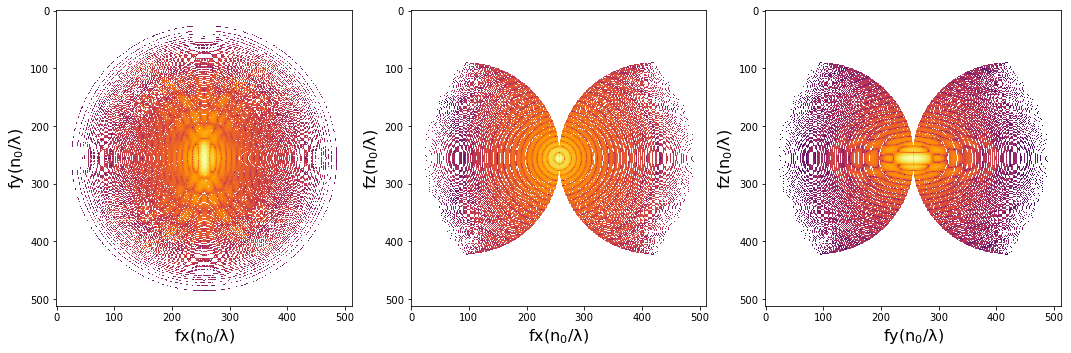

In [6]:
# 假設rowSize = colSize =ffsize
# 假設一般情況ffsize=512
# f_3D   = np.zeros((ffsize,ffsize,ffsize), dtype=np.complex64)  #scattering potential spatial domain的格子數
# F_3D   = np.zeros((ffsize,ffsize,ffsize), dtype=np.complex64)  #scattering potential frequency domain的格子數
F_3Dx   = np.zeros((ffsize,ffsize,ffsize), dtype=np.complex64)
# C_3D   = np.zeros((ffsize,ffsize,ffsize), dtype=np.float32)


# du_sp = cupy.zeros((ffsize,ffsize), dtype=cupy.complex64)
dPhase = cupy.zeros((ffsize,ffsize), dtype=cupy.float32)
dAmp = cupy.zeros((ffsize,ffsize), dtype=cupy.float32)
dU_rytov = cupy.zeros((ffsize,ffsize), dtype=cupy.complex64)
dF = cupy.zeros((ffsize*ffsize*ffsize), dtype=cupy.complex64)
dFx = cupy.zeros((ffsize*ffsize*ffsize), dtype=cupy.complex64)
dC = cupy.zeros((ffsize*ffsize*ffsize), dtype=cupy.int32)

for filePath in tqdm(glob.glob(opt_field+'/*')[:]):
    
    reconFlag, angX, angY, phiImg, ampImg  = importOpticalField(filePath)
#     print(np.sin(angX))
    if(reconFlag == True):
#         phiImg = center_crop(phiImg, ffsize, ffsize)
#         ampImg = center_crop(ampImg, ffsize, ffsize)
        src_y, src_x = np.shape(phiImg)
        
        dPhase = cupy.array(phiImg.copy())
        dAmp = cupy.array(ampImg.copy())
        
        MedianFilter_gpu(grid=((src_x + 32 - 1) // 32, (src_y + 32 - 1) // 32), block=(32,32), args=(dPhase, src_x, src_y))
        MedianFilter_gpu(grid=((src_x + 32 - 1) // 32, (src_y + 32 - 1) // 32), block=(32,32), args=(dAmp, src_x, src_y))
        
        du_sp = gpu_resize(cupy.array(phiImg.copy()),cupy.array(ampImg.copy()), src_x, src_y, ffsize, ffsize)
        dU_rytov  = (cupy.fft.fft2(cupy.fft.fftshift(du_sp)))

        fx0 = fm0 * np.sin(0)
        fy0 = fm0 * np.sin(0)
        fz0 = np.sqrt(fm02 - fx0*fx0 - fy0*fy0)
        EwaldSphere_kernel2(grid=((ffsize + 32 - 1) // 32, (ffsize + 32 - 1) // 32), block=(32,32)
                           , args=(dU_rytov, dF, dC, np.float32(fx0), np.float32(fy0), np.float32(fz0), np.float32(angX), np.float32(angY)
                           , np.float32(fm0), np.float32(df), ffsize, ffsize, ffsize))
        

dFx[dC>0] = dF[dC>0]/dC[dC>0]
F_3Dx = cupy.asnumpy(cupy.transpose(cupy.reshape(dFx,(ffsize, ffsize, ffsize)), (2,1,0)))
du_sp = None
dU_rytov = None
dF = None
# dC = None

# disp_3Dx = np.fft.fftshift(C_3D)

plot_F_domain(np.fft.fftshift(F_3Dx), ffsize, df)

In [ ]:
dF_src = cupy.fft.fftshift(cupy.array(F_3Dx.copy()))
dF_dst = dF_src
dC = cupy.transpose(cupy.fft.fftshift(cupy.reshape(dC,(ffsize, ffsize, ffsize))),(2,1,0))

for i in range(1,50):
    improveES(grid=((ffsize + 16 - 1) // 16, (ffsize + 16 - 1) // 16, (ffsize + 4 - 1) // 4), block=(16,16,4)
           , args=(dF_dst, dF_src, dC, np.float32(fx0), np.float32(fy0), np.float32(fz0), np.float32(fm0), np.float32(df), ffsize, ffsize, ffsize))
    dF_src = dF_dst
#     print(np.sum(cupy.asnumpy(dC)))
    

disp_3Dx = cupy.asnumpy(dF_dst)
# disp_3Dx = cupy.asnumpy(dC)

dF_src = None
dC = None

plot_F_domain(disp_3Dx, ffsize, df)

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

disp_F = np.fft.fftshift(F_3Dx)
disp_C = disp_3Dx

def f(x):    
#     plt.figure(figsize=(10,10))
# #     plt.imshow(np.log10(np.abs(np.fft.fftshift(F_3Dx[:,:,x]))), cmap='gray')
#     plt.imshow((disp_3Dx[:,:,x]), cmap='gray')
#     plt.show()
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6),sharex=False, sharey=True)
    ax1=axes[0,0]
    ax2=axes[0,1]
    ax3=axes[0,2]
    ax4=axes[1,0]
    ax5=axes[1,1]
    ax6=axes[1,2]
    
    xy_RI = np.abs(disp_F[:,:,x])
    xz_RI = np.abs(disp_F[:,x,:])
    yz_RI = np.abs(disp_F[x,:,:])
    
    xy_mask = disp_C[:,:,x]
    xz_mask = disp_C[:,x,:]
    yz_mask = disp_C[x,:,:]
    
    im1 = ax1.imshow(xy_RI, vmin=1.567, vmax=1.59)
    ax2.imshow(xz_RI, vmin=1.567, vmax=1.59)
    ax3.imshow(yz_RI, vmin=1.567, vmax=1.59)
    im4 = ax4.imshow(xy_mask, vmin=0, vmax=1)
    ax5.imshow(xz_mask, vmin=0, vmax=1)
    ax6.imshow(yz_mask, vmin=0, vmax=1)

    cbar_ax1 = fig.add_axes([0.9, 0.53, 0.01, 0.32]) 
    cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical').set_label(label='RI',size=14)
    
    cbar_ax2 = fig.add_axes([0.9, 0.13, 0.01, 0.32]) 
    cbar2 = fig.colorbar(im4, cax=cbar_ax2, orientation='vertical').set_label(label='mask',size=14)
    plt.show() 

interact(f, x=widgets.IntSlider(min=0,max=np.shape(F_3Dx)[2]-1,step=1,value=128))

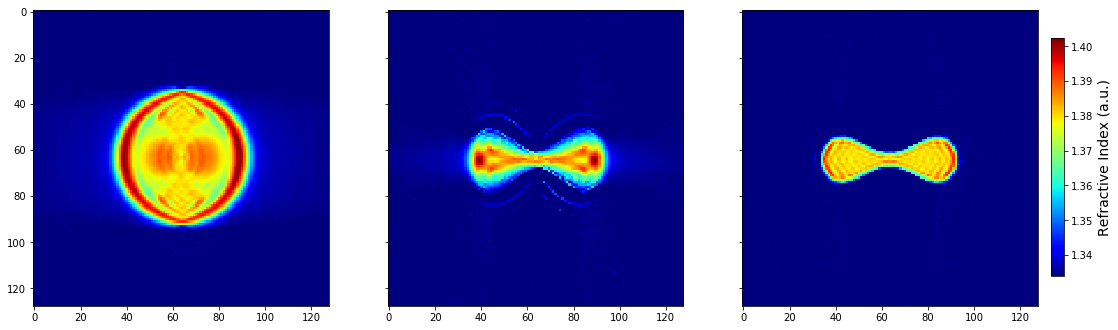

In [7]:
# dF_3Dx = cupy.fft.fftshift(dF_dst)
dF_3Dx = cupy.array(F_3Dx.copy())
dF_3D   = cupy.fft.ifftn(cupy.divide(dF_3Dx,dx))
dF_3D_2 = cupy.divide(dF_3Dx,dx)
dn_3D   = cupy.multiply(cupy.sqrt(cupy.add(cupy.divide(dF_3Dx,-k2), 1)), n_med)


# Positive constraint
dn_3D[cupy.less(cupy.real(dn_3D),n_med)] = cupy.real(n_med)+cupy.imag(dn_3D[cupy.less(cupy.real(dn_3D),n_med)])
dn_3D[cupy.less(cupy.imag(dn_3D),0)]     = cupy.real(dn_3D[cupy.less(cupy.imag(dn_3D), 0)])


for iter in tqdm(range(0,100)): 
    
    dF_3D = cupy.multiply(cupy.subtract(cupy.divide(cupy.multiply(dn_3D,dn_3D),n_med2),1),-k2)
    dF_3D = cupy.fft.fftn(dF_3D)
    dF_3D[cupy.not_equal(dF_3D_2,0)] = dF_3D_2[cupy.not_equal(dF_3D_2,0)]
    dF_3D   = cupy.fft.ifftn(dF_3D)    
    dn_3D   = cupy.multiply(cupy.sqrt(cupy.add(cupy.divide(dF_3D,-k2), 1)), n_med)
    
#     Positive constraint
    dn_3D[cupy.less(cupy.real(dn_3D),n_med)] = cupy.real(n_med)+cupy.imag(dn_3D[cupy.less(cupy.real(dn_3D),n_med)])
    dn_3D[cupy.less(cupy.imag(dn_3D),0)]     = cupy.real(dn_3D[cupy.less(cupy.imag(dn_3D), 0)])
    

dF_3D = cupy.multiply(cupy.subtract(cupy.divide(cupy.multiply(dn_3D,dn_3D),n_med2),1),-k2)
dF_3D = cupy.fft.fftn(dF_3D)
dF_3D[cupy.not_equal(dF_3D_2,0)] = dF_3D_2[cupy.not_equal(dF_3D_2,0)]
dF_3D   = cupy.fft.ifftn(dF_3D)    
dn_3D   = cupy.multiply(cupy.sqrt(cupy.add(cupy.divide(dF_3D,-k2), 1)), n_med)

dn_3D =  cupy.fft.fftshift(dn_3D);
dn_3D[cupy.less(cupy.real(dn_3D),n_med)] = n_med+1j*cupy.imag(dn_3D[cupy.less(cupy.real(dn_3D),n_med)])



n_3D = cupy.asnumpy(cupy.transpose(dn_3D,(0,2,1)))

dn_3D = None
dF_3D = None
dF_3Dx = None
dF_3D_2 = None

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),sharex=False, sharey=True)
ax1=axes[0]
ax2=axes[1]
ax3=axes[2]
xy = (center_crop(np.real(n_3D[:,:,ffsize//2]),128,128))
xz = np.transpose(center_crop(np.real(n_3D[:,ffsize//2,:]),128,128))
yz = np.transpose(center_crop(np.real(n_3D[ffsize//2,:,:]),128,128))
Vmin = 1.334
Vmax = np.max(np.real(n_3D))
im1 = ax1.imshow(xy, cmap=plt.cm.jet, vmin=Vmin, vmax=Vmax)
ax2.imshow(xz, cmap=plt.cm.jet, vmin=Vmin, vmax=Vmax)
ax3.imshow(yz, cmap=plt.cm.jet, vmin=Vmin, vmax=Vmax)

cbar_ax = fig.add_axes([0.91, 0.23, 0.01, 0.55]) 
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='vertical').set_label(label='Refractive Index (a.u.)',size=14)
plt.show() 

## CPU Computing

In [ ]:
# 假設rowSize = colSize =ffsize
# 假設一般情況ffsize=512
f_3D   = np.zeros((ffsize,ffsize,ffsize), dtype=np.complex64)  #scattering potential spatial domain的格子數
F_3D   = np.zeros((ffsize,ffsize,ffsize), dtype=np.complex64)  #scattering potential frequency domain的格子數
F_3Dx   = np.zeros((ffsize,ffsize,ffsize), dtype=np.complex64)
C_3D   = np.zeros((ffsize,ffsize,ffsize), dtype=np.int)

u_sp   = np.zeros((ffsize,ffsize), dtype=np.complex64)
U_rytov= np.zeros((ffsize,ffsize), dtype=np.complex64)

for filePath in tqdm(glob.glob(opt_field+'/*')[:500]):
    
    reconFlag, angX, angY, phiImg, ampImg  = importOpticalField(filePath)
    if(reconFlag == True):
        phiImg[np.isnan(phiImg)] = 0
        phiImg[np.isinf(phiImg)] = 0
        ampImg[np.isnan(ampImg)] = 1
        ampImg[np.isinf(ampImg)] = 1
        ampImg[ampImg==0]= 0.01;
        ampImg = np.absolute(ampImg)
        
        phiImg = ndimage.median_filter(resize(phiImg, (ffsize,ffsize) ), size=3)
        ampImg = ndimage.median_filter(resize(ampImg, (ffsize,ffsize) ), size=3)
        
        u_sp  = np.log(ampImg) + 1j*phiImg
        du_sp  = cupy.fft.fftshift(cupy.array(u_sp.copy()))
        U_rytov = cupy.asnumpy(cupy.fft.fft2(du_sp))
        
        fx0 = fm0 * np.sin(angY)
        fy0 = fm0 * np.sin(angX)
        fz0 = np.sqrt(fm02 - fx0*fx0 - fy0*fy0)
        
        for row in range(-ffsize//2,ffsize//2):
            for col in range(-ffsize//2,ffsize//2):

                Fx = row * df
                Fy = col * df
                
                fx = Fx + fx0
                fy = Fy + fy0                
                fz = np.sqrt(fm02-fx*fx-fy*fy)

                Fz = fz-fz0

                Nx = row
                Ny = col
                
                if(fm02-fx0*fx0-fy0*fy0 >= 0 and fm02-fx*fx-fy*fy >=0):
                    flag = True
                else:
                    flag = False
                    
                if (flag ==True and Nx>=-ffsize/2 and Nx<ffsize/2 and  Ny>=-ffsize/2 and Ny<ffsize/2):
                    Nx = int(np.mod(Nx , ffsize))
                    Ny = int(np.mod(Ny , ffsize))
                    Nz = int(np.mod(int(np.round(Fz/df)) , ffsize))
                    F_3D[Nx,Ny,Nz] += (1j*4*np.pi*fz) * U_rytov[Nx,Ny];
                    C_3D[Nx,Ny,Nz] += 1
                    
F_3Dx[C_3D>0] = F_3D[C_3D>0]/C_3D[C_3D>0]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),sharex=True, sharey=True)
ax1=axes[0]
ax2=axes[1]
ax3=axes[2]
xy = np.log10(np.abs(F_3D[:,:,ffsize//2]))
xz = np.log10(np.abs(F_3D[:,ffsize//2,:]))
yz = np.log10(np.abs(F_3D[ffsize//2,:,:]))
ax1.imshow(xy)
ax2.imshow(xz)
ax3.imshow(yz)
plt.show() 

In [ ]:
f_3D   = np.fft.ifftn(F_3Dx/dx)
F_3D_2 = F_3Dx/dx
n_3D   = np.sqrt(-f_3D/k2 + 1) *n_med


# Positive constraint
n_3D[np.real(n_3D)<n_med] = n_med+1j*np.imag(n_3D[np.real(n_3D)<n_med])
n_3D[np.imag(n_3D)<0]     = np.real(n_3D[np.imag(n_3D)<0])


for iter in tqdm(range(0,100)): 
    
    f_3D = -k2*(n_3D*n_3D/n_med2-1)
    F_3D = np.fft.fftn(f_3D)
    F_3D[F_3D_2!=0] = F_3D_2[F_3D_2!=0]
    f_3D   = np.fft.ifftn(F_3D)    
    n_3D   = np.sqrt(-f_3D/k2 + 1) *n_med
    
#     Positive constraint
    n_3D[np.real(n_3D)<n_med] = n_med+1j*np.imag(n_3D[np.real(n_3D)<n_med])
    n_3D[np.imag(n_3D)<0]     = np.real(n_3D[np.imag(n_3D)<0]) 
    

f_3D = -k2*(n_3D*n_3D/n_med2-1)
F_3D = np.fft.fftn(f_3D)
F_3D[F_3D_2!=0] = F_3D_2[F_3D_2!=0]
f_3D   = np.fft.ifftn(F_3D)    
n_3D   = np.sqrt(-f_3D/k2 + 1) *n_med

n_3D =  np.fft.fftshift(n_3D);
n_3D[np.real(n_3D)<n_med] = n_med+1j*np.imag(n_3D[np.real(n_3D)<n_med])


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),sharex=False, sharey=False)
ax1=axes[0]
ax2=axes[1]
ax3=axes[2]
xy = np.real(n_3D[:,:,ffsize//2-10])
xz = np.real(n_3D[:,ffsize//2,:])
yz = np.real(n_3D[ffsize//2,:,:])
im1 = ax1.imshow(xy, vmin=1.567, vmax=1.59)
ax2.imshow(xz, vmin=1.567, vmax=1.59)
ax3.imshow(yz, vmin=1.567, vmax=1.59)

cbar_ax = fig.add_axes([0.93, 0.23, 0.01, 0.55]) 
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='vertical').set_label(label='RI',size=14)
plt.show() 